In [1]:
# Extensions for code formatting and inline plotting
%load_ext nb_black
#%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Library importing
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
import pmdarima as pm

warnings.filterwarnings("ignore")  # Ignoring warnings to reduce text spam.

# Preferences
sns.set(rc={"figure.figsize": (15, 8.27)})
pd.set_option("display.float_format", "{:,}".format)
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", None)

<IPython.core.display.Javascript object>

In [3]:
# Data retrieval function
def retrieve_data():
    os.chdir('..')
    cwd = os.getcwd()
    if 'data' in os.listdir():
        os.chdir(cwd + '\\data')
        df = pd.read_csv('data.csv', sep=';', decimal=',')
        df['ds'] = pd.to_datetime(df[['year','month']].assign(day=1))
        df['y'] = df['quantity'].round().astype('int64')
        df.drop(columns=['year','month','quantity'], inplace=True)
        return df

<IPython.core.display.Javascript object>

In [4]:
# data object
df = retrieve_data()

<IPython.core.display.Javascript object>

In [5]:
df.head(20)

,ds,y
0,2010-01-01,10205914
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
4,2010-05-01,12035571
5,2010-06-01,10134094
6,2010-07-01,9561953
7,2010-08-01,9845679
8,2010-09-01,12236500
9,2010-10-01,10949143


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'quantity'),
 Text(0.5, 1.0, 'Medicine sales over time')]

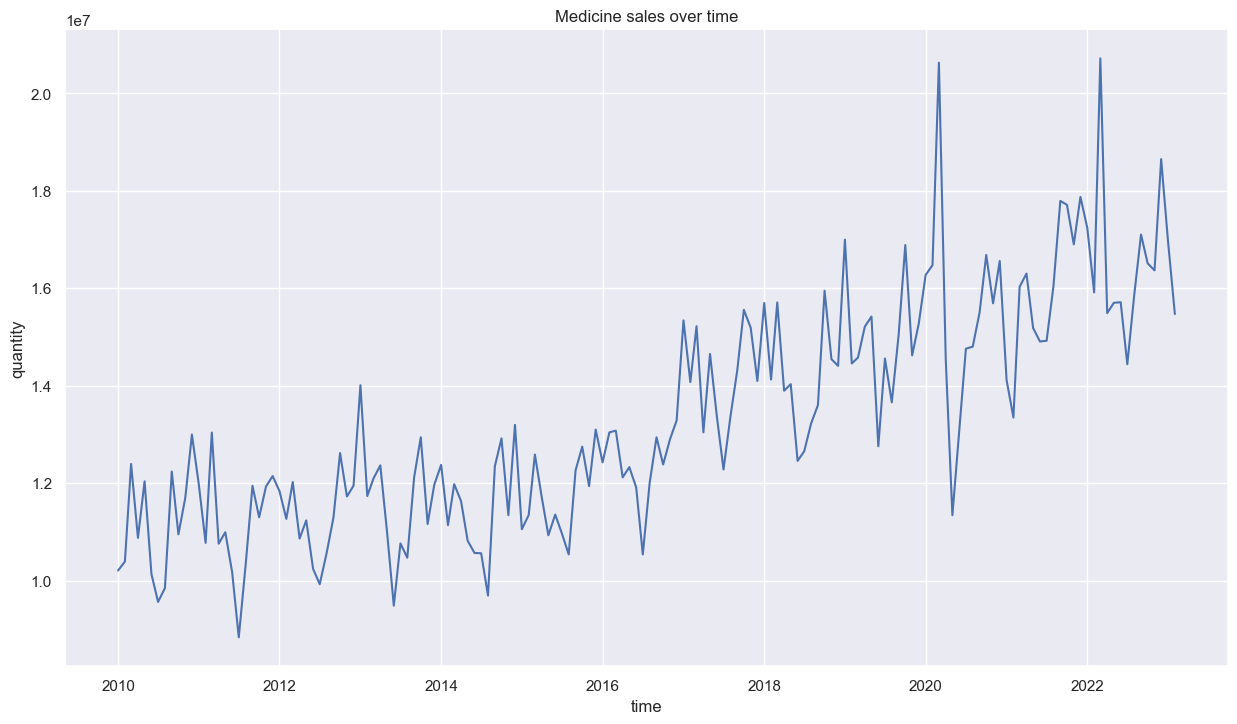

<IPython.core.display.Javascript object>

In [7]:
fig = sns.lineplot(df, x='ds', y='y')
fig.set(xlabel='time', ylabel='quantity', title='Medicine sales over time')

In [8]:
from prophet import Prophet

<IPython.core.display.Javascript object>

In [31]:
model = Prophet(seasonality_mode='multiplicative')
#model.add_country_holidays(country_name="LT")
model.fit(df)

19:55:40 - cmdstanpy - INFO - Chain [1] start processing
19:55:40 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

In [32]:
future = model.make_future_dataframe(periods=60, freq='MS')

<IPython.core.display.Javascript object>

In [33]:
forecast = model.predict(future)

<IPython.core.display.Javascript object>

In [34]:
forecast.tail(5).T

,213,214,215,216,217
ds,2027-10-01 00:00:00,2027-11-01 00:00:00,2027-12-01 00:00:00,2028-01-01 00:00:00,2028-02-01 00:00:00
trend,"20,182,029.42609576","20,236,348.34184457","20,288,915.034504704","20,343,233.950253513","20,397,552.866002318"
yhat_lower,"20,250,417.57908943","18,905,272.715667974","20,292,657.896548018","19,963,437.20430208","19,165,770.33118132"
yhat_upper,"22,493,516.540743224","21,156,404.078457683","22,599,510.95629422","22,227,126.19838371","21,429,556.703614544"
trend_lower,"19,967,041.865001712","20,015,426.506360985","20,062,809.651177563","20,112,802.862722598","20,161,694.00488064"
trend_upper,"20,418,042.24989517","20,478,370.827259954","20,537,361.871573098","20,598,056.550941218","20,657,680.332376268"
multiplicative_terms,0.05853800794718425,-0.007157074451932505,0.05789492855064848,0.03720095256470493,-0.005606027890692908
multiplicative_terms_lower,0.05853800794718425,-0.007157074451932505,0.05789492855064848,0.03720095256470493,-0.005606027890692908
multiplicative_terms_upper,0.05853800794718425,-0.007157074451932505,0.05789492855064848,0.03720095256470493,-0.005606027890692908
yearly,0.05853800794718425,-0.007157074451932505,0.05789492855064848,0.03720095256470493,-0.005606027890692908


<IPython.core.display.Javascript object>

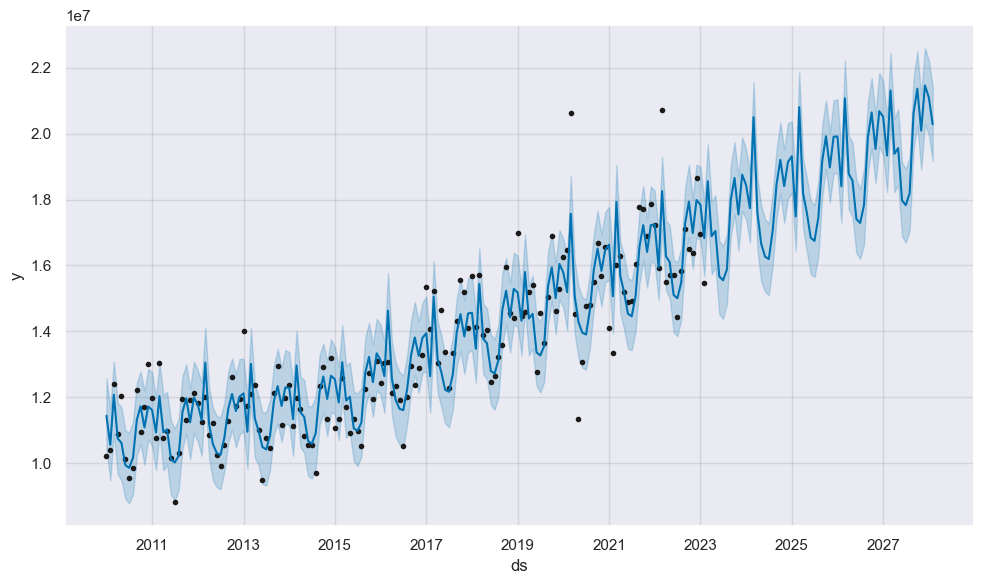

<IPython.core.display.Javascript object>

In [35]:
plt = model.plot(forecast)

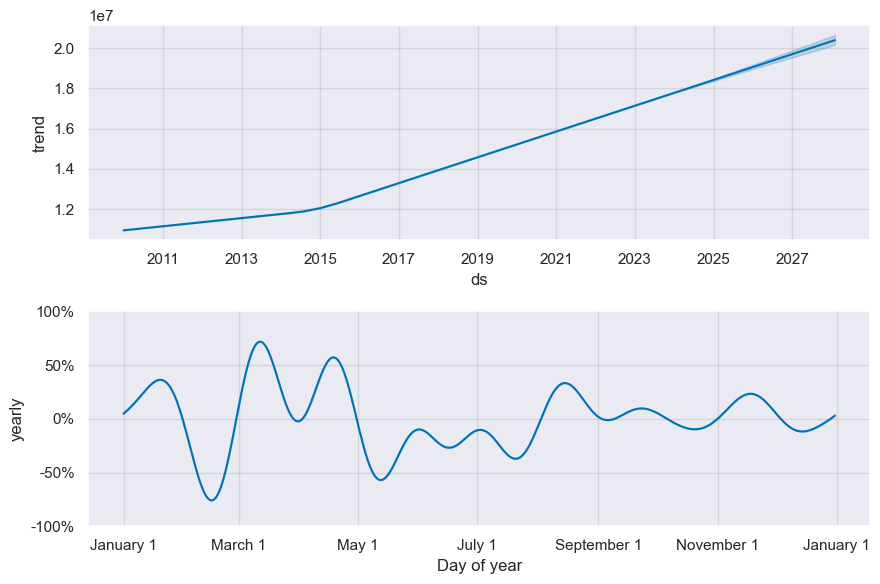

<IPython.core.display.Javascript object>

In [36]:
plt = model.plot_components(forecast)

In [21]:
df.head()

,ds,y
0,2010-01-01,10205914
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
4,2010-05-01,12035571


<IPython.core.display.Javascript object>